In [16]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

### Neuroelectronics 

In the resting state, the cytosol of a neuron is negatively charged relative to the extracellular fluid with a potential of about -70$\mathrm{mV}$ which is maintained by ion pumps. There is a nonzero potential because 3-4 nm thick lipid bilayer blocks ions. Clearly the membrane is behaving like a capacitor.

At the same time, the membrane has a finite resistance (net conductance) as it contains highly specific ion channels which allow the passage of ions. What we have then is an RC circuit. 

### Single-compartment models

Neurons have highly complex morphologies which make them difficult to model. For this reason we commonly test our models on a single compartment. That is we forget about axons and dendrites temporarily and consider a single compartment bounded by a membrane. If we inject a current $I_{inj}$ into such a compartment we have the following ODE

\begin{equation*}
C\frac{dV}{dt} = I_{inj} - I
\end{equation*}

where $I$ is the membrane current, $R$ is the total membrane resistance to ion flux and $C$ the total capacitance. However, in general, currents, resistances, and capacitances are not uniformly distributed across the membrane. Because of this we instead use capacitance per unit area, current per unit area, and resitance per unit area. Dividing through by the total area gives

\begin{equation*}
C\frac{dV}{dt} = I_{inj} - I \rightarrow c_{m}\frac{dV}{dt} = \frac{I_{inj}}{A} - i_{m}
\end{equation*}

When we develop a model for the membrane potential we are imposing conditions on $i_{m}$. Some models, like the Hodgkin-Huxley model do this at the level of single ion channels. Others utilize a simpler description for the sake of brevity and computational efficiency. These simpler models also offer insight on the non-linearities in neurons due to voltage dependence of things like leakage current. I will start with the simpler cases and then build up to a full description using individual ion channels

### Leaky compartments

From here on I will refer to conductances rather than resistances as this is what is most commonly used in neuroscience. 

The simplest of non-linear models ignores all conductances besides a leakage conductance. This means there are only two currents: the injected current and a leakage current. The leakage current per unit area is $i_{m} = g_{L}(V - E_{L})$ where $g_{L}$ is the leakage conductance per unit area which is the source of the non-linearity. We can now expand our general expression from above

\begin{eqnarray}
c_{m}\frac{dV}{dt} &=& \frac{I_{inj}}{A} - g_{L}(V - E_{L})\\
\end{eqnarray}

Temporarily, we won't assume a value for $A$ so we can write it in an alternative form

\begin{eqnarray}
\tau_{m}\frac{dV}{dt} &=& E_{L} - V + R_{m}I_{inj} \\
\end{eqnarray}

and so the voltage is found by integrating

\begin{eqnarray}
V(t) &=& \int (E_{L} - V + R_{m}I_{inj})dt\\
\end{eqnarray}

where $\tau_{m}=r_{L}c_{m}$ and $R_{m}$ is the **total** resistance of the compartment. $\tau_{m}$ is a relaxation constant of the same kind used to describe an RC circuit. You can see that the total resistance $R_{m}$ will scale linearly with the area but the time constant $\tau_{m}$ remains the same. Let's go ahead and simulate such a compartment using parameters $R_{m}$, $g_{L}$, $\tau_{m}$ informed by real-world experiments.

### A python framework

Essentially any model we can define will be of the form 

\begin{equation*}
C\frac{dV}{dt} = I_{inj} - I
\end{equation*}

so we can give ourselves the ability to simulate a variety of cases with an object-oriented approach that allows us to define $I_{inj}$ as well as channels that mediate ion flux. 

In [3]:
class Compartment():

    def __init__(self, time, cap=281e-12, area=1, v_rest=-70e-3, injected=None):

        #area is in mm^2
        #cap is the total capacitance

        self.dt = time[1]-time[0]
        if injected is not None:
            self.injected = injected
        else:
            self.injected = np.zeros_like(time)

        self.time = time
        self.voltage = v_rest; self.current = 0
        self.voltage_arr = np.zeros_like(time)
        self.current_arr = np.zeros_like(time)

        self.channels = []
        self.cap = cap
        self.area = area
        
    def add_channel(self, channel):
        self.channels.append(channel)

    def step_voltage(self,injected=0):

        dv = (self.dt/self.cap)*((injected/self.area)-self.current)
        self.voltage += dv

    def step_current(self):

        self.current = 0
        for channel in self.channels:
            channel.step(self.voltage)
            self.current += channel.current

    def simulate(self):

        for i in range(len(self.time)):
            self.step_current()
            self.current_arr[i] = self.current
            self.step_voltage(injected[i])
            self.voltage_arr[i] = self.voltage

Now we will define a base Channel class which can be instantiated and added to the channel array of Compartment. 

In [5]:
class Channel():
    def __init__(self, conductance, reversal):

        self.conductance = conductance
        self.reversal = reversal

    def step(self, voltage):
        self.current = self.conductance*(voltage-self.reversal)

The simplest case is a single compartment with no channels at all $i_{m}=0$, so we would expect a simple linear voltage-time relationship. Let's see

In [8]:
import numpy as np
import matplotlib.pyplot as plt

T = 0.1 #1s
dt = 1e-3 #1ms
t = np.linspace(0, T, int(T/dt))

injected=np.piecewise(t, [t < 0.025, t >= 0.025, t >= 0.075], [0, 5e-9, 0])
neuron = Compartment(t, injected=injected)
neuron.simulate()

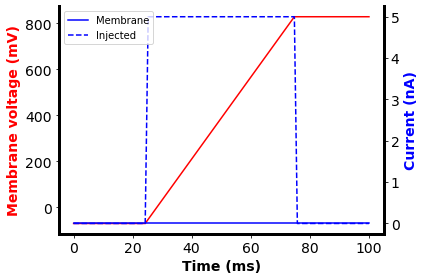

In [38]:
#plot
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (ms)', color='black', size=14, weight='bold')
ax1.set_ylabel('Membrane voltage (mV)', color='red', size=14, weight='bold')
ax1.plot(t*1e3, neuron.voltage_arr*1e3, color='red')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Current (nA)', color='blue', size=14, weight='bold')
ax2.plot(t*1e3, neuron.current_arr*1e9, color='blue', label='Membrane')
ax2.plot(t*1e3, neuron.injected*1e9, color='blue', linestyle='--', label='Injected')

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.spines['left'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['right'].set_linewidth(3)

plt.setp(ax1.get_yticklabels(),
            fontsize=14)
plt.setp(ax1.get_xticklabels(),
            fontsize=14)
plt.setp(ax2.get_yticklabels(),
            fontsize=14)
plt.legend(loc='upper left')
fig.tight_layout()
plt.show()

Now lets add 10,000 "leaky" Channels to Compartment and again inject 50ms current at 5nA

In [39]:
neuron = Compartment(t, injected=injected)
leaks = [Channel(100e-12,-70e-3) for i in range(100)]
neuron.channels += leaks
neuron.simulate()

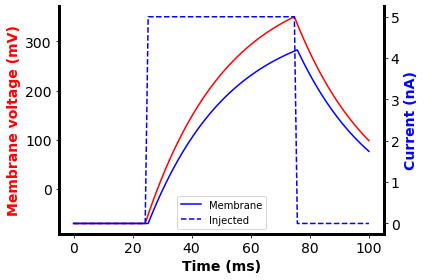

In [40]:
#plot
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (ms)', color='black', size=14, weight='bold')
ax1.set_ylabel('Membrane voltage (mV)', color='red', size=14, weight='bold')
ax1.plot(t*1e3, neuron.voltage_arr*1e3, color='red')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Current (nA)', color='blue', size=14, weight='bold')
ax2.plot(t*1e3, neuron.current_arr*1e9, color='blue', label='Membrane')
ax2.plot(t*1e3, neuron.injected*1e9, color='blue', linestyle='--', label='Injected')

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.spines['left'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['right'].set_linewidth(3)

plt.setp(ax1.get_yticklabels(),
            fontsize=14)
plt.setp(ax1.get_xticklabels(),
            fontsize=14)
plt.setp(ax2.get_yticklabels(),
            fontsize=14)
plt.legend()
fig.tight_layout()
plt.show()

### Simulating channels

This is great but lets say we want to define some more realistic channels. One class of channels important to neuroscience are voltage-dependent i.e. their probability of being open is a function of the voltage. If $n$ is the probability that a channel is open, then it will evolve according to

\begin{equation*}
\frac{dn}{dt} = \alpha_{n}(V)(1-n) - \beta_{n}(V)n
\end{equation*}

where $\alpha_{n}$ is the opening rate and $\beta_{n}$ is the closing rate. Generally, $\alpha_{n}$ and $\beta_{n}$ are determined by fitting them to the experimental data.

In [17]:
class DelayedRectifier(Channel):

    def __init__(self, conductance, reversal):

        self.conductance = conductance
        self.reversal = reversal

        self.current_arr = []
        self.state = 0 #closed
        self.p_open = 0

    def alpha(self,v):
        return 0.01*(v+55)/(1-np.exp(-0.1*(v+55))) #opening rate

    def beta(self,v):
        return 0.125*np.exp(-0.0125*(v+65)) #closing rate

    def step(self,v):

        """Update the open probability"""

        dp=(self.alpha(v)*(1-self.p_open)-self.beta(v)*self.p_open)*dt
        self.p_open += dp
        self.state = np.random.binomial(1, self.p_open)
        self.current = self.conductance*(v-self.reversal)*self.state
        self.current_arr.append(self.current)

    def simulate(self, v):

        """Run a full simulation for known voltage"""

        self.current = np.zeros(*v.shape)
        for i in range(len(v)-1):
            self.step(v[i])
            self.current[i] = self.state

In [18]:
neuron = Compartment(t, injected=injected)
rectifiers = [DelayedRectifier(100e-12,-70e-3) for i in range(10000)]
neuron.channels += rectifiers
neuron.simulate()

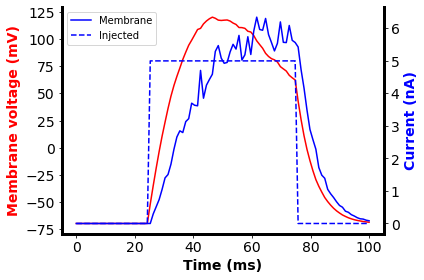

In [21]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (ms)', color='black', size=14, weight='bold')
ax1.set_ylabel('Membrane voltage (mV)', color='red', size=14, weight='bold')
ax1.plot(t*1e3, neuron.voltage_arr*1e3, color='red')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Current (nA)', color='blue', size=14, weight='bold')
ax2.plot(t*1e3, neuron.current_arr*1e9, color='blue', label='Membrane')
ax2.plot(t*1e3, neuron.injected*1e9, color='blue', linestyle='--', label='Injected')

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.spines['left'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['right'].set_linewidth(3)

plt.setp(ax1.get_yticklabels(),
            fontsize=14)

plt.setp(ax1.get_xticklabels(),
            fontsize=14)

plt.setp(ax2.get_yticklabels(),
            fontsize=14)

plt.legend()
fig.tight_layout()
plt.show()